In [1]:
# Evalúa el modelo guardado en 04_model_training.ipynb
# usando el mismo esquema de datos y partición train/test.

import os

import joblib
import numpy as np
import pandas as pd

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# -------------------------------------------------------
# 1. CARGA DEL DATASET LIMPIO
# -------------------------------------------------------

In [2]:
DATA_PATH = "../data/processed/spotify_clean.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró el archivo en {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print(f"✅ Dataset cargado: {df.shape[0]:,} filas x {df.shape[1]} columnas")


✅ Dataset cargado: 232,724 filas x 15 columnas


# -------------------------------------------------------
# 2. TRANSFORMACIONES CONSISTENTES
#    (duration_min y eliminación de duration_ms)
# -------------------------------------------------------


In [3]:
df["duration_min"] = df["duration_ms"] / 60000
df.drop(columns="duration_ms", inplace=True)


# -------------------------------------------------------
# 3. DEFINICIÓN DE X E Y (como en 03 y 04)
# -------------------------------------------------------

In [4]:
X = df.drop(columns=["is_hit", "popularity"])
y = df["is_hit"]


# -------------------------------------------------------
# 4. CARGA DEL LabelEncoder GUARDADO EN 04_model_training
# -------------------------------------------------------

In [5]:
ENCODER_PATH = "../models/genre_label_encoder.joblib"
MODEL_PATH = "../models/spotify_hit_classifier.joblib"

if not os.path.exists(ENCODER_PATH):
    raise FileNotFoundError(f"No se encontró el encoder en {ENCODER_PATH}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"No se encontró el modelo en {MODEL_PATH}")

le_genre: LabelEncoder = joblib.load(ENCODER_PATH)
modelo = joblib.load(MODEL_PATH)

# Aplicar el mismo encoding de género
X_tree = X.copy()
X_tree["genre"] = le_genre.transform(X_tree["genre"])

# -------------------------------------------------------
# 5. MISMO TRAIN/TEST SPLIT (random_state=42)
# -------------------------------------------------------


In [6]:
X_train_tree, X_test_tree, y_train, y_test = train_test_split(
    X_tree,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTamaños de los conjuntos para evaluación:")
print("X_train_tree:", X_train_tree.shape)
print("X_test_tree :", X_test_tree.shape)


Tamaños de los conjuntos para evaluación:
X_train_tree: (186179, 13)
X_test_tree : (46545, 13)



# -------------------------------------------------------
# 6. PREDICCIONES Y MÉTRICAS
# -------------------------------------------------------

In [7]:
y_pred = modelo.predict(X_test_tree)

if hasattr(modelo, "predict_proba"):
    y_proba = modelo.predict_proba(X_test_tree)[:, 1]
else:
    y_proba = None

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

if y_proba is not None:
    roc = roc_auc_score(y_test, y_proba)
else:
    roc = np.nan

print("\n=== MÉTRICAS EN TEST ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}  ← MÉTRICA PRINCIPAL")
if not np.isnan(roc):
    print(f"ROC AUC  : {roc:.3f}")



=== MÉTRICAS EN TEST ===
Accuracy : 0.895
Precision: 0.300
Recall   : 0.983
F1-score : 0.459  ← MÉTRICA PRINCIPAL
ROC AUC  : 0.986


# -------------------------------------------------------
# 7. MATRIZ DE CONFUSIÓN
# -------------------------------------------------------

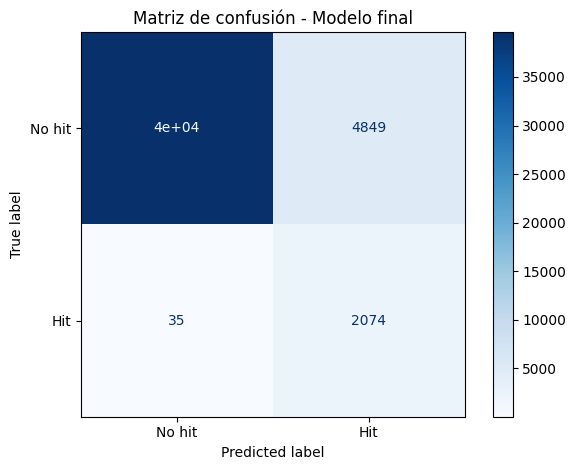

In [8]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No hit", "Hit"]
)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Modelo final")
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 8. CURVA ROC (SI HAY PROBABILIDADES)
# -------------------------------------------------------


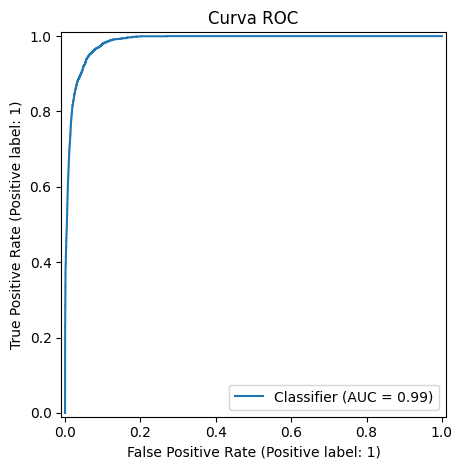

In [9]:
if y_proba is not None:
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title("Curva ROC")
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------
# 9. CURVA PRECISION-RECALL
# -------------------------------------------------------


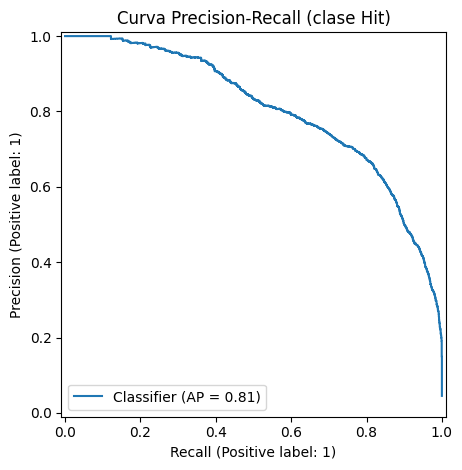

In [10]:
if y_proba is not None:
    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title("Curva Precision-Recall (clase Hit)")
    plt.tight_layout()
    plt.show()